References:
- https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset


### Import packages

In [1]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
%matplotlib inline

### Hyperparameters

In [2]:
image_size = 80
batch_size_train = 1000
batch_size_val = 1000
num_workers = 0
shuffle_loader = False
root = 'datasets/'
TARGET_ATTR = 'Young' #'Wearing_Hat', 'Bald', 'Bangs', 'Eyeglasses', 'Male', 'No_Beard', 'Smiling', 'Young', 

In [3]:
ATTR = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
ATTR = {attr: attr_idx for attr_idx, attr in enumerate(ATTR.split(' '))}
target_attr_index = ATTR[TARGET_ATTR]
target_attr_index

39

### Load Dataset & Create dataloader

In [4]:
transform = transforms.Compose([
    # transforms.Resize(image_size),
    # transforms.CenterCrop(image_size),
    # transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

order = list(range(160000))
# import random
# random.seed(1)
# random.shuffle(order)

dataset_train = Subset(CelebA(root=root, split='train', transform=transform, target_type='attr', download=False), order)
# dataset_train = CelebA(root=root, split='train', transform=transform, target_type='attr', download=False)
dataset_val = CelebA(root=root, split='valid', transform=transform, target_type='attr', download=False)

In [5]:
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=shuffle_loader, num_workers=num_workers, drop_last=False)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size_val, shuffle=False, num_workers=num_workers, drop_last=False)

In [6]:
len(dataset_train), len(dataset_val)

(160000, 19867)

### Example of visualization

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])
torch.Size([1000, 3, 218, 178])


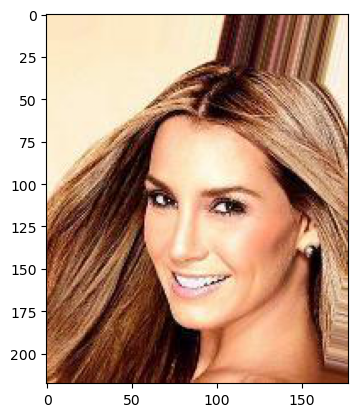

In [7]:
denorm = transforms.Normalize((-1,),(2,))

def im_show(img, ax=None):
    img_denorm = denorm(img)
    img_t = torch.permute(img_denorm, (1,2,0))
    if ax is not None:
        ax.imshow(img_t)
    else:
        plt.imshow(img_t)

img_example, label_example = next(iter(loader_train))
# plt.imshow(torch.permute(img_example[0], (1,2,0)))
im_show(img_example[0])
print(label_example[0])
print(img_example.shape)

In [8]:
attr_true_list_val = []
attr_false_list_val = []
cnt = [30, 30]
for i, (im, lab) in enumerate(loader_val):
    for j, l in enumerate(lab[...,target_attr_index]):
        if l==1 and cnt[1] > 0:
            attr_true_list_val.append(j)
            cnt[1] -= 1
        elif l==0 and cnt[0] > 0:
            attr_false_list_val.append(j)
            cnt[0] -= 1
    if sum(cnt) == 0 : break
print(attr_true_list_val)
print(attr_false_list_val)

[0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 38, 39, 41, 43]
[1, 7, 11, 14, 15, 18, 25, 26, 27, 35, 36, 37, 40, 42, 49, 52, 56, 69, 77, 78, 79, 80, 89, 92, 94, 96, 105, 106, 111, 112]


### Ablation (Covariance gap rank)

In [ ]:
from fair_streaming_pca_pytorch import FairStreamingPCA

rank_list = [
    0, 'mean', 1, 2, 4, 8,
]
n_iter = 5
block_size = len(dataset_train) // n_iter

V_list = []
N_list = []
exp_var_list = []
exp_var_0_list = []
exp_var_1_list = []
for r in rank_list:
    pca = FairStreamingPCA(TARGET_ATTR, device='mps')
    pca.fit(
        loader=loader_train,
        target_unfair_dim=r,
        target_pca_dim=400,
        n_iter_unfair=n_iter,
        n_iter_pca=n_iter,
        block_size_unfair=block_size,
        block_size_pca=block_size,
        constraint='mean' if r=='mean' else ('all' if r > 0 else 'vanilla'),
        verbose=False,
        seed=1
    )
    V_list.append(pca.V.cpu())
    N_list.append(pca.N.cpu())
    pca.transform(loader=loader_val,)
    exp_var_list.append(pca.explained_variance_ratio)
    exp_var_0_list.append(pca.explained_variance_ratio_group[0])
    exp_var_1_list.append(pca.explained_variance_ratio_group[1])

In [ ]:
os.makedirs(f'figures/{1}/')

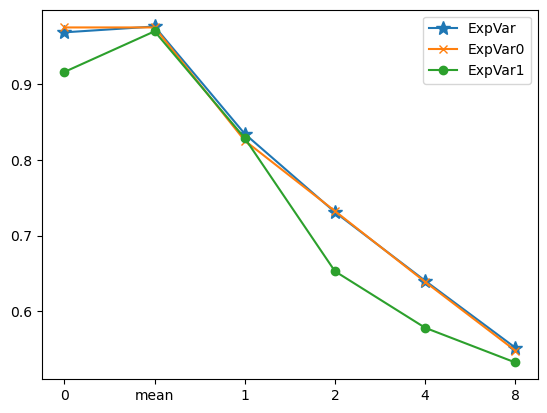

In [ ]:
plt.plot(list(map(str, rank_list)), exp_var_list, label='ExpVar', marker='*', markersize=10)
plt.plot(list(map(str, rank_list)), exp_var_0_list, label='ExpVar0', marker='x')
plt.plot(list(map(str, rank_list)), exp_var_1_list, label='ExpVar1', marker='o')
plt.legend()
plt.savefig('figures/RankAblation_all1_expvar.pdf')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


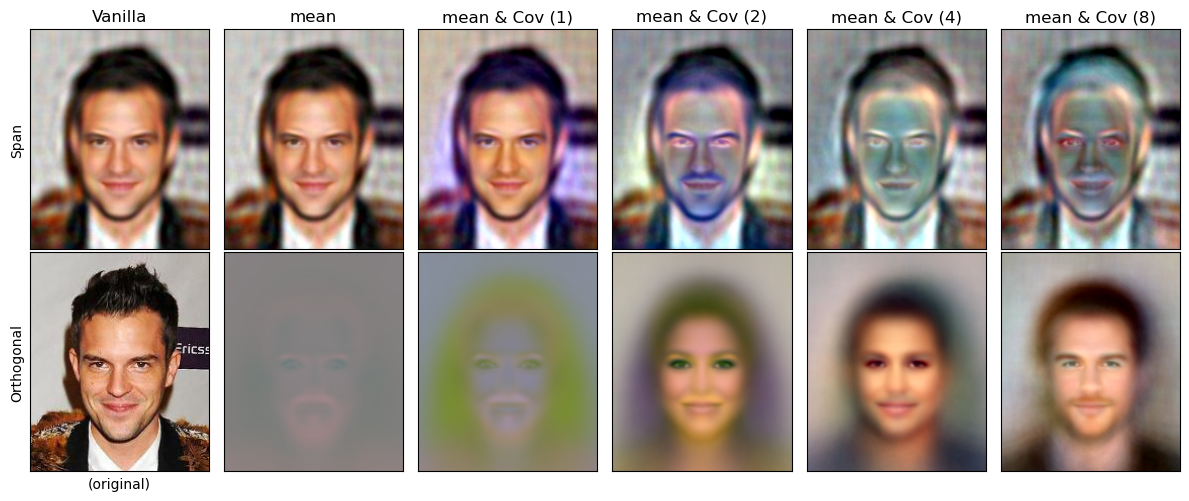

In [ ]:
fig, axes = plt.subplots(2, len(rank_list), figsize=(2*len(rank_list), 5))
axes[0][0].set_ylabel('Span')
axes[1][0].set_ylabel('Orthogonal')

index = 32
img, _ = dataset_val[index]
for i, r in enumerate(rank_list):
    pca.V = V_list[i].to(pca.device)
    projected = pca.transform(img).cpu()
    im_show(projected[0], axes[0][i])
    if r == 0:
        axes[0][i].title.set_text(f'Vanilla')
    elif r == 'mean':
        axes[0][i].title.set_text(f'mean')
    else:
        axes[0][i].title.set_text(f'mean & Cov ({r})')
    axes[0][i].get_xaxis().set_ticks([])
    axes[0][i].get_yaxis().set_ticks([])
    if r == 'mean' or r > 0 :
        pca.V = N_list[i].to(pca.device)
        orthogonal = pca.transform(img).cpu()
        im_show(orthogonal[0], axes[1][i])
    else:
        im_show(img, axes[1][i]) # original
        axes[1][i].set_xlabel('(original)')
        
    axes[1][i].get_xaxis().set_ticks([])
    axes[1][i].get_yaxis().set_ticks([])

fig.tight_layout()
# fig.savefig('figures/RankAblation_all.pdf')
# fig.savefig(f'figures/RankAblation_all_false{index}.pdf')
# fig.savefig(f'figures/RankAblation_all_true{index}.pdf')